In [12]:
library(caret)
library(pander)
library(doMC)
library(plyr)
library(dplyr)
library(Matrix)
library(data.table)
library(stringr)
library(AnomalyDetection)

# Register CPU core count
registerDoMC(cores=23)

# Utility function for use with % frequency tables
frqtab <- function(x, caption) {
    round(100*prop.table(table(x)), 3)
}

# Utility function to round values in a list
# but only if they are numeric

round_numeric <- function(lst, decimals=2) {
    lappy(lst, function(x){
        if (is.numeric(x)) {
            x <- round(x, decimals)
        }
        return(x)
    })
}

# Utility function for model comparison

summod <- function(cm, fit) {
    summ <- list(k = fit$finalModel$k,
                metric = fit$metric,
                value = fit$results[fit$resultes$k == fit$finalModel$k, fit$metric],
                TN = cm$table[1,1], # True negatives
                TP = cm$table[2,2], # True positives
                FN = cm$table[1,2], # False negatives
                FP = cm$table[2,1], # False positives
                acc = cm$overall["Accuracy"], 
                sens = cm$byClass["Sensitivity"],
                spec = cm$byClass["Specificity"],
                PPV = cm$byClass["Positive Predicted Value"],
                NPV = cm$byClass["Negative Prediced Value"])
    round_numeric(summ)
}

# Utility function to normalize the data

normalize <- function(x){
    num <- x - min(x)
    denom <- max(x) - min(x)
    return (num/denom)
}

#Function to timeslice the data however user would like

timeslice <- function(df, slice, interval) {
    if (slice == 'secs'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval))
        return(df)
    }
    else if (slice == 'mins'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 60))
        return(df)
    }
    else if (slice == 'hours') {
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 3600))
        return(df)
    }
    else if (slice == 'days'){
        df <- subset(df, df$StartTime <= df$StartTime[1] + (interval * 86400))
        return(df)
    }
    else
      error <- print("Please enter a valid time interval.")
      return(error)
}

In [2]:
# Read .binetflow file into dataframe

#flowdata_csv <- read.csv("capture20110810.binetflow", colClasses = c("character", "numeric", "character", 
                                                                    #"character","character","character",
                                                                    #"character","character","character",
                                                                    #"character","character","numeric", 
                                                                    #"numeric", "numeric", "character"), 
                                                                    #strip.white = TRUE, sep = ',')

flowdata_csv <- fread("capture20110810.binetflow", colClasses = c("myPosixCt", "numeric", "character", 
                                                                  "character","character","character",
                                                                  "character","character","character",
                                                                  "character","character","numeric", 
                                                                  "numeric","numeric", "character"), 
                                                                  sep = 'auto')

# Set POSIX formatting for StartTime

options(set.seconds="6")
flowdata_csv$StartTime <- as.POSIXct(flowdata_csv$StartTime, format = "%Y/%m/%d %H:%M:%OS")
    
# Trim leading and trailing whitespace

str(flowdata_csv)

Read 2824636 rows and 15 (of 15) columns from 0.360 GB file in 00:00:14
Classes ‘data.table’ and 'data.frame':	2824636 obs. of  15 variables:
 $ StartTime: POSIXct, format: "2011-08-10 09:46:59" "2011-08-10 09:47:00" ...
 $ Dur      : num  1.03 1.01 3.06 3.11 3.08 ...
 $ Proto    : chr  "tcp" "tcp" "tcp" "tcp" ...
 $ SrcAddr  : chr  "94.44.127.113" "94.44.127.113" "147.32.86.89" "147.32.86.89" ...
 $ Sport    : chr  "1577" "1577" "4768" "4788" ...
 $ Dir      : chr  "->" "->" "->" "->" ...
 $ DstAddr  : chr  "147.32.84.59" "147.32.84.59" "77.75.73.33" "77.75.73.33" ...
 $ Dport    : chr  "6881" "6881" "80" "80" ...
 $ State    : chr  "S_RA" "S_RA" "SR_A" "SR_A" ...
 $ sTos     : chr  "0" "0" "0" "0" ...
 $ dTos     : chr  "0" "0" "0" "0" ...
 $ TotPkts  : num  4 4 3 3 3 3 4 4 4 5 ...
 $ TotBytes : num  276 276 182 182 182 182 244 252 252 352 ...
 $ SrcBytes : num  156 156 122 122 122 122 124 132 132 208 ...
 $ Label    : chr  "flow=Background-Established-cmpgw-CVUT" "flow=Background-Es

## Twitter AnomalyDetection Package

Recently Twitter OpenSourced an internal library, written in R, that can be used to discovery anomalies within time series data. The inherent time series nature of NetFlow data will allow us to use this library to potentially discover anomalies that may exist within the dataset.

https://github.com/twitter/AnomalyDetection

This package uses an algorithm called Seasonal Hybrid ESD, which builds upon Generalized ESD. This implementation is built to detect both local and global anomalies that may exist within a given dataset.

### Generalized Extreme Studentized Deviate (ESD)

Generalized ESD is an algorithm that was developed to detect one or more outliers in a univariate data set that follows an approximately normal distribution.

When working with Generalized ESD, we must specify an "upper bound" of anomalies within a given dataset.

Given this upper bound, $r$, the algorithm essentially performs $r$ seperate tests : a test for one outlier, a test for two outliers, and so on up to $r$ outliers.

This can be seen as :

$$ R_{i} = \frac{\max_{i}|x_{i}-\bar x|}{s} $$

with $x$ and $s$ denoting the sample mean and sample standard deviation, respectively.

This will remove the observation that maximizes $|x_{i}-\bar x|$ and then recompute the above statistic with $n-1$ observations, repeating the process until $r$ observations have been removed. This results in the $r$ statistics $R_{1}, R_{2},...,R_{r}$.

$$ Region : \lambda_{i} = \frac{(n-i) \, t_{p, \, n-i-1}}{\sqrt{(n-i-1+t_{p, \, n-i-1}^{2}) (n-i+1)}}\hspace{.2in} i = 1, 2, \ldots, r$$

where $t_{p,v}$ is the $100p$ percentage point from the t-distribution with $v$ degrees of freedom and 

$$ p = 1 - \frac{a}{2(n-i+1)} $$

The number of outliers is determined by findings the largest $i$ such that $R_{i} > \lambda_{i}$.

### Seasonal-Hybrid-ESD

This is a combination of algorithms that revolve around the idea that there is seasonality that exists within data that we're looking at. This seasonality can prove challenging when trying to find anomalies in a given dataset that may not look like anomalies from a global perspective, with respect to the data. Seasonality introduces a concept similar to windowing data and trying to spoint local anomalies in a given window (season) that may have been overlooked from a global perspective.

####TODO : 
* Add elementwise breakdown of each ESD Algorithm to flow data
* Add breakdown to S-H-ESD Explanation

In [3]:
# Subset and normalize data

#Function to carve up by timeslice / interval

#flowdata_slice <- timeslice(flowdata_csv, 'mins', 10)

labels <- c("Label")

tot_pkts <- c("TotPkts")
duration <- c("Dur")
tot_bytes <- c("TotBytes")
src_bytes <- c("SrcBytes")


flowdata_tot_pkts <- subset(flowdata_csv, select = c(tot_pkts))
flowdata_duration <- subset(flowdata_csv, select = c(duration))
flowdata_tot_bytes <- subset(flowdata_csv, select = c(tot_bytes))
flowdata_src_bytes <- subset(flowdata_csv, select = c(src_bytes))

#flowdata_slice <- subset(flowdata_csv, select = c(cont_vars, labels))

#flowdata_slice <- sample_n(flowdata_slice, 50000)

In [5]:
res_src_bytes = AnomalyDetectionVec(flowdata_src_bytes[1:40000], max_anoms = .0009, plot=TRUE, period = 6)
res_tot_pkts = AnomalyDetectionVec(flowdata_tot_pkts[1:40000], max_anoms = .0009, plot=TRUE, period = 6)
res_tot_bytes = AnomalyDetectionVec(flowdata_tot_bytes[1:40000], max_anoms = .0009, plot=TRUE, period = 6)
res_dur = AnomalyDetectionVec(flowdata_duration[1:40000], max_anoms = .0009, plot=TRUE, period = 6)

In [6]:
res_src_bytes$anoms
res_tot_pkts$anoms
res_tot_bytes$anoms
res_dur$anoms

,index,anoms
1,114,60214264
2,117,2625276
3,124,132816366
4,130,282534
5,137,10056796
6,166,448464
7,174,238088
8,178,15514984
9,208,60363789
10,320,60334389


,index,anoms
1,114,72157
2,121,4360
3,124,162760
4,137,23574
5,166,8223
6,174,4036
7,178,19678
8,179,3851
9,190,3314
10,208,51576


,index,anoms
1,114,61638544
2,117,2636496
3,124,137136528
4,137,10855048
5,178,15918352
6,208,60964440
7,320,61164753
8,334,10742562
9,335,1641273
10,431,1199483


,index,anoms
1,114,3599.972
2,160,3599.815
3,166,3599.977
4,178,3599.954
5,324,3599.994
6,1070,3599.989
7,1222,3599.998
8,1336,3599.771
9,1756,3599.756
10,1786,3599.819


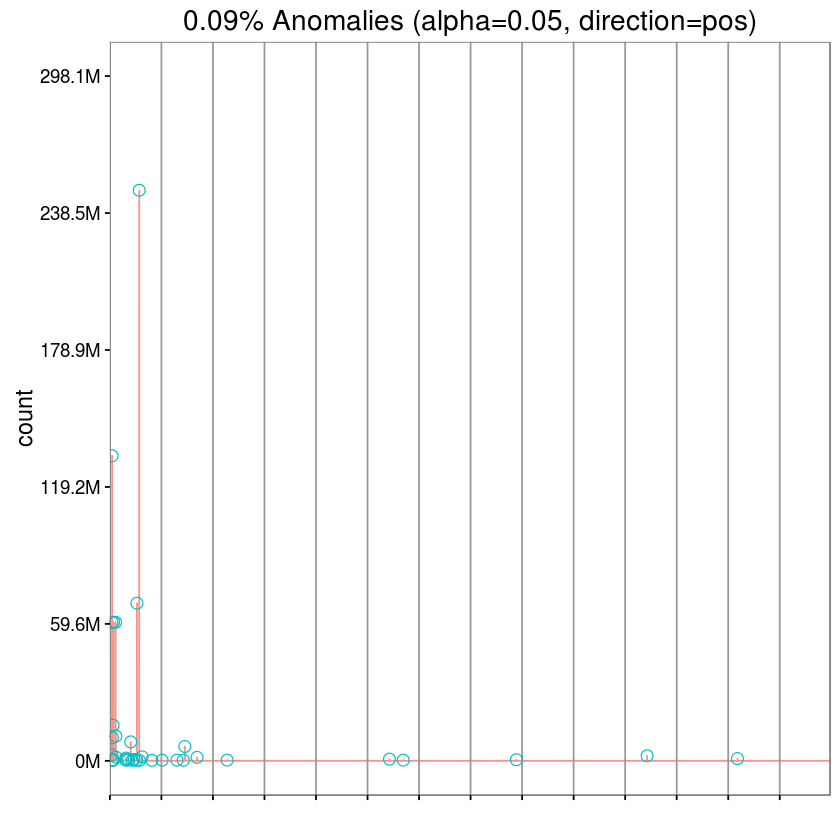

In [8]:
res_src_bytes$plot

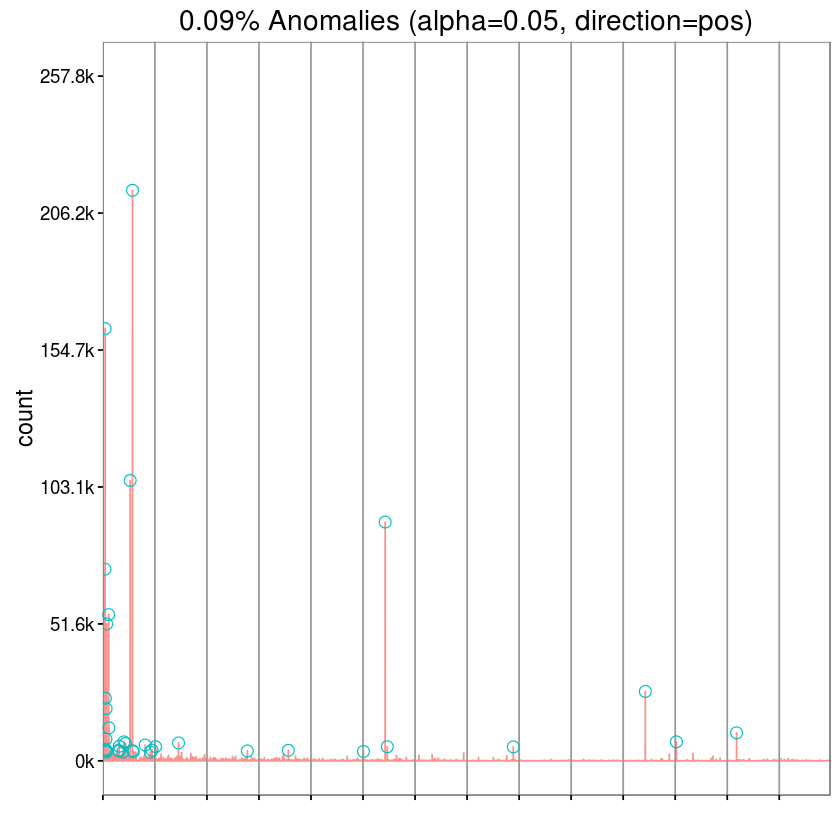

In [9]:
res_tot_pkts$plot

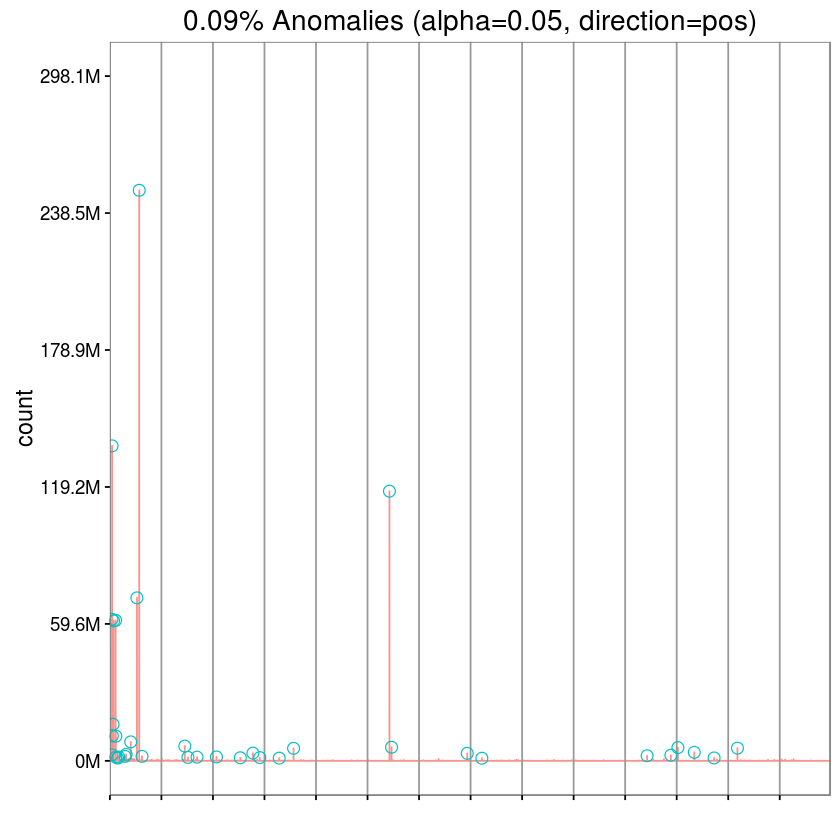

In [10]:
res_tot_bytes$plot

## References

[1] Generalized ESD Test for Outliers http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm